# Using K-Nearest Neighbor Classification to Predict Tennis Player Success: A Study of Title Wins



### Introduction

Tennis is a popular sport that dates back to 12th century France, open to both beginner and professional-level play (Lorge). Modern-day professional tennis is played in a tournament style with there being a number of different tournaments athletes can compete in around the world. Some examples of well known major tennis tournaments include Wimbledon, The French Open, and The US Open. Winning a tournament results in a title win. 

In our report we hope to learn more about what it takes for players to obtain a title. Using classification, we hope to answer the predictive question: **Given their best rank, number of seasons played, and historical prize money earnings, can we determine if a tennis player has held a title?** 

The dataset we will be using is from ultimatetennisstatistics.com and includes a variety of data on the current Top 500 tennis players. The dataset includes their height, weight, age, favorite surface to play on, and much more. We have chosen the categories that we believe to be the most interesting and best pertaining to answering our question. 


### Preliminary Exploratory Data Analysis

In [4]:
library(repr)
library(cowplot)
library(readr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ dplyr   1.0.9
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ 

We will begin by first reading our data in from the google drive link that was provided for us on canvas for this data set and assigning it to an object called raw_data.

In [5]:
raw_data <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")
raw_data

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23 (14-03-1996),Netherlands,Left-handed,Wikipedia,495 (60),342 (05-08-2019),Gijs Brouwer,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Now that we have assigned the raw data frame to an object, it is time to clean and wrangle it into a tidy format. We will do so by renaming columns, selecting only the columns we need, and changing the data type of the columns.

In [6]:
renamed_columns <- raw_data |>
    rename("Best.Rank" = "Best Rank") |>
    rename("Prize.Money" = "Prize Money")

data <- renamed_columns |>
    select("Best.Rank", "Seasons", "Titles", "Prize.Money")

tidy <- data |>
    separate(col = Best.Rank, into = c("best.rank", "date.of.best.rank"), 
             sep = " ", , convert = TRUE) |>
    select("best.rank", "Seasons", "Titles", "Prize.Money") |>
    mutate(Titles = as.logical(Titles))   |>
    mutate_if(is.logical, ~replace_na(., FALSE)) |>
    mutate(Titles = as_factor(Titles)) |>
    mutate(Prize.Money = parse_number(Prize.Money, na = c("NA", "Nothing")))

Now that we are finished tidying the data, we can create a 3/4 split on the data set to partition it into training and testing sets.

In [7]:
tennis_split <- initial_split(tidy, prop = 0.75, strata = Titles)
tennis_train <- training(tennis_split) |> na.omit()
tennis_test <- testing(tennis_split) |> na.omit()

After splitting the tidy data set into training and testing data (with the ratio being 3:1), we summarized the training data into a table. The table reports the number of observations in each class (title vs no title), the means and the standard deviations of the predictor variables we plan to use in our analysis.

In [8]:
summarized_table <- tennis_train |>
    group_by(Titles) |>
    summarize(average_best_rank = mean(best.rank, na.rm = TRUE),
              sd_best_rank = sd(best.rank, na.rm = TRUE),
              average_seasons = mean(Seasons, na.rm = TRUE),
              sd_seasons = sd(Seasons, na.rm = TRUE),
              average_prize_money = mean(Prize.Money, na.rm = TRUE),
              sd_prize_money = sd(Prize.Money, na.rm = TRUE),
              number_of_observations = n()) 
summarized_table

Titles,average_best_rank,sd_best_rank,average_seasons,sd_seasons,average_prize_money,sd_prize_money,number_of_observations
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,162.28643,101.02247,4.718593,3.609920,736687.5,1032614,199
TRUE,20.38028,15.94935,11.211268,4.513204,11298131.1,17817677,71


We now move on to visualizing the training data with a box plot showcasing the difference in the predictor variables when grouping them accordingly to their Title.

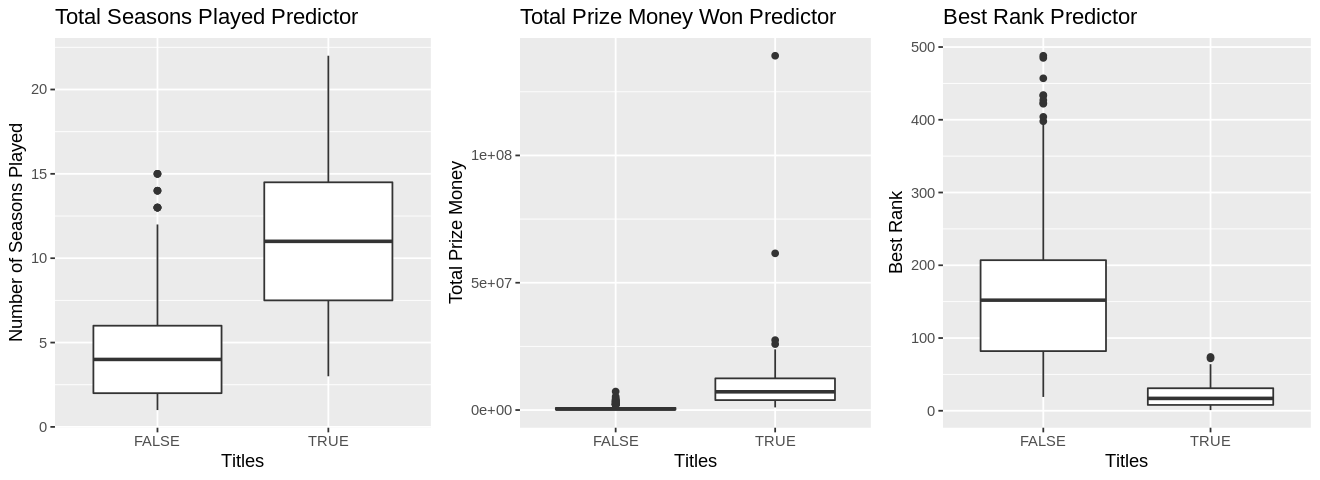

In [8]:
options(repr.plot.width = 11, repr.plot.height = 4)

plot_best_rank <- tennis_train |>
    ggplot(aes(x = Titles, y = best.rank)) +
    geom_boxplot() +
    ylab("Best Rank") +
    ggtitle("Best Rank Predictor")

plot_seasons <- tennis_train |>
    ggplot(aes(x = Titles, y = Seasons)) +
    geom_boxplot() +
    ylab("Number of Seasons Played") +
    ggtitle("Total Seasons Played Predictor")

plot_prize_money <- tennis_train |>
    ggplot(aes(x = Titles, y = Prize.Money)) +
    geom_boxplot() +
    ylab("Total Prize Money") +
    ggtitle("Total Prize Money Won Predictor")

plot_grid(plot_seasons, plot_prize_money, plot_best_rank, nrow = 1)

In these box plots, false indicates no title wins while true is at least one title win. From these box-plots we are able to see that the variables we have chosen should be fairly successful predictors. The interquartile ranges for each box plot do not overlap, indicating that there is a difference between the 2 classifications when using these predictors. To further explore this, the plot below puts Seasons played and Best rank together to see their relationship with title wins.  

Warning message:
“Removed 126 rows containing missing values (geom_point).”


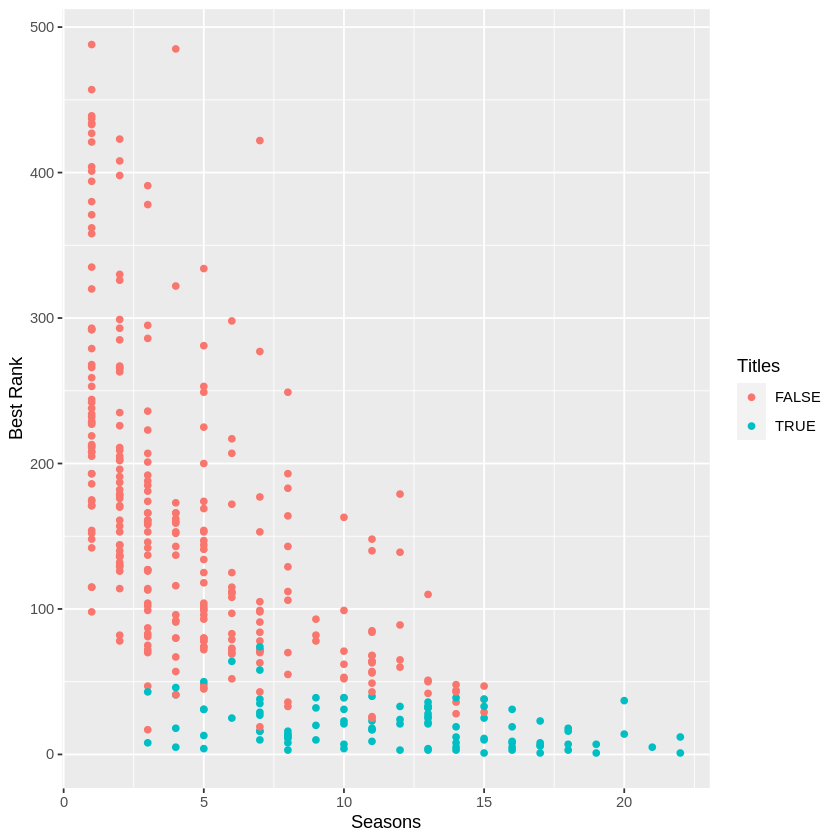

In [9]:
plot <- tidy |>
    ggplot(aes(x = Seasons, y = best.rank))+
    geom_point(aes(color = Titles))+
    xlab("Seasons") +
    ylab("Best Rank")
plot

From this plot it is clear to see that all title holders fall above the rank of 100 and with a higher number of seasons played, the fewer non title holders we see. This follows our intuition as it makes sense that those with better ranking and more experience playing would be more likely to win a title. This will be helpful for our model as there is a clear differentiation between those who hold a title and those who do not. 

### Methods

In order to perform a K-nearest neighbors classification, we will center and scale the data so that the classification is not overly influenced by one predictor. Then, we will use cross-validation to tune the model and find the K-value with the highest accuracy. With that K-value, we will fit it to the training data, use that to predict the testing data, and see how accurate the model actually is. One way that we will visualize the results is by making a table showing the confusion matrix of the predictions compared to the actual data.

The predictor variables we have chosen from this data set are best rank, number of seasons played and prize money earned. These were chosen as we see them as the most relevant in differentiating players and describing their success in playing tennis. Their best rank gives us information on how well they play compared to other players while number of seasons played shows a player's experience, and prize money earned also plays a part in indicating a player's performance, all of which should be strong indicators of their ability to play tennis.

In [10]:
# Scale and Center Recipe
tennis_recipe <- recipe(Titles ~ Seasons + best.rank + Prize.Money, data = tennis_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# KNN Tune Model Specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Cross Validation
training_vfold <- vfold_cv(tennis_train, v = 10, strata = Titles)

# K Values Vector
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

# Training Fit Workflow
training_fit <- workflow() |>
    add_recipe(tennis_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = training_vfold, grid = k_vals) |>
    collect_metrics()

In [12]:
# Best K neighbors
best_k <- training_fit |>
    filter(.metric == "accuracy") |>
    arrange(mean) |>
    tail(1) |>
    select(neighbors) |>
    pull()

# KNN Specification with best K
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Final Model Workflow
tennis_fit <- workflow() |>
    add_recipe(tennis_recipe) |>
    add_model(best_spec) |>
    fit(data = tennis_train)

# Model Predictions
tennis_predictions <- predict(tennis_fit, tennis_test) |>
    bind_cols(tennis_test)

# Model Prediction Metrics
tennis_metrics <- tennis_predictions |>
    metrics(truth = Titles, estimate = .pred_class)

# Model Confusion Matrix
tennis_conf_mat <- tennis_predictions |>
    conf_mat(truth = Titles, estimate = .pred_class)

tennis_metrics
tennis_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9278351
kap,binary,0.7916539


          Truth
Prediction FALSE TRUE
     FALSE    72    6
     TRUE      1   18

### Discusion 

As seen in the table above, we were able to make a model that is able to predict with ~93% accuracy whether a player holds one or more titles given best rank, seasons played, and historical prize money earnings. In the confusion matrix it can be seen that this model seems to predict better on the non title holding players and this is most likely due to there being a larger sample size for the model to work on for this category. This outcome is what we expected for the most part, as in our preliminary data exploration it was clear that there was a rather significant difference shown between non title holders and title holders based off of our predictors. Our model's accuracy is perhaps a bit higher than we thought we could achieve however if this were to be conducted again in the future, we would consider oversampling the title winners so that the ratio between the two classifications are less skewed. 

This model could be helpful for players in determining where they stand amongst their competition as we build a better understanding of what goes into making a title-holding tennis player. A future project could look into determining whether or not a player will win a title given their stats and also information about the specific tournament they will play in. Can we predict the likelihood a given player will win a match? How accurate can this prediction be? Such questions could be very significant for the sports betting industry. As silly as that may sound, sports betting can play a significant role in generating revenue for the government through taxation. In 2022 sports betting set a quarterly revenue record of 1.68 billion dollars in the United States (Greenburg). Given these circumstances, being able to predict the outcome for a sport in any capacity could lead to a significant pay off.  


### Citations

Greenberg, D. (2022) *Sports betting industry just set a quarterly revenue record, Front Office Sports.* Available at: https://frontofficesports.com/sports-betting-industry-just-set-a-quarterly-revenue-record/ (Accessed: March 11, 2023). 

Lorge, B. S., &amp; Bruce, M. G. L. (2023, March 5). Tennis. Encyclopædia Britannica. Retrieved April 8, 2023, from https://www.britannica.com/sports/tennis 

Player Stats for Top 500 Players. Ultimatetenissstatistics.com (Version 1) [Data set].
https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS
